# Derin Öğrenme ile Zaman Serileri Tahmin Modelleri

Zaman serileri zamana bağlı olark değişen gözlemlerden oluşan sıralı verilerdir. Zaman serisi tahmin modellerinde amaç geçmişteki gözlem değerlerinden gelecekteki durumların dağılımını araştırmaktır.

Zaman serisi modelleri:
1. Geleneksel yöntemler
   
   1.1. Doğrusal modeller (ARMA, ARIMA vs.) durağanlık varsayımı ile çalışır. Durağanlık bir serinin ortalmasının ve varyansının zamandan bağımsız sabit olması demektir. Dolayısıyla ARIMA modellerini çalışabilmesi için öncelikle zaman serisinin durağan hale getirilmesi gereklidir. Bunun için sezonsal ARIMA, ya da fark alma gibi metotlar geliştirilmiştir.
    
    1.2. Doğrusal olmayan modeller (ARCH, GARCH, TAR, NAR, NARX gibi)

Geleneksel yöntemlerde tekrarlı bir yapı söz konusu ve durağanlık şartının olması makine öğrenmesi yöntemlerinin gereksinimini doğurur.

2. Makine öğrenmesi yöntemleri  
    2.1. SVM, ANN, DT vb.

3. Derin öğrenme yöntemleri  
    3.1. RNN, LSTM, GRU

Birinci ve ikinci kategorideki yaklaşımlarla ilgili birçok alanda örnek çaışma bulunabilir. Derin öğrenme çalşmalarının ise diğerlerinie göre yeni olduğunu söyleyebiliriz. 

# Zaman serisinde çerçeveleme

Zaman serilerinin derin öğrenme ile modellenebilmesi için bir takım dönüşümlerin yapılması gereklidir. 

Karar verilmesi gerekenler:
- Tahmin adımı sayısı (Kaç sonraki veri tahmin edilecek)
- Çıktının boyut sayısı
- Multivariate vs Univariate
- Zaman gecikmesi (kaç önceki veri ile tahmin)

Aşağıda k zaman sonraki y değişkenini tahmin ediyoruz. Sadece bir değişken kullanarak bunu yapıyoruz. Şimdiki zaman t ise t+k zaman sonraki y değeri geçmişteki x değerlerinden şimdiki x değerine kadar olan durumlara bağlı olacak.

$$y_{t+k} = f(x_{t-n}, x_{t-n+1}, ..., x_t)$$

Multivariate olması durumunda özellik sayısı kadar x değerleri olacaktır. Bu durumu daha iyi anlamak için görsel incelenebilir.

![pencere_kaydirma.drawio.png](pencere_kaydirma.drawio.png)

# Derin Öğrenme Algoritmaları
Zaman serileri sıralı veriler olduğundan derin öğrenme algoritmalarından RNN, LSTM ve GRU nun sıralı verilerde(konuşma verisi, görüntü verisi gibi) daha iyi sonuç verdiği bilinmektedir. 



## RNN
RNN'ler geçmiş veriler ile gelecekteki verilerin arasındaki ilişkiyi öğrenme boyunca hafızada tutar. 
![image2.png](image2.png)

$$h_t = tanh(U(x_t, h_{t-1}))$$
$$ o_t = \sigma(W, S_t)$$


## LSTM

Bir RNN varyantıdır. Uzun süreli zaman ilişkilerinde daha başarılı sonuç verir. Gizli durumu(hidden state)(h), hücre durumu(cell state)(C) vardır. Grafikten görüldüğü gibi Ct bir önceki hücre durumuna (C_t-1) e, bir önceki gizli duruma(h_t-1) ve şimdiki girdiye (xt) ye bağlıdır. Hücre içinde bilgiler forget gate, input gate ve output gate kapıları ile tutulur. Bunlara ilişkin formüller aşağıda verilmiştir.  

![image4.png](image4.png)
![imageformul.png](imageformul.png)

## GRU
Farklı olarak update ve reset gate eklenmiştir.

![image5.png](image5.png)
![imageformul2.png](imageformul2.png)

## Veri seti

Bu çalışmada Pekindeki hava kirliliği veri seti kullanılacaktır. İlgili veri seti linkten indirilebilir: https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

# Uygulama ve Deneysel sonuçlar

In [1]:
# PAKETLER
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, max_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from datetime import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, TimeDistributed, Bidirectional, ConvLSTM2D, Dropout
from tensorflow.keras.models import model_from_json

In [2]:
# VERİ SETİ
df = pd.read_csv('PRSA_Data_Aotizhongxin_20130301-20170228.csv', index_col=0)

In [3]:
df.shape

(35064, 17)

In [4]:
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
No,,,,,,,,,,,,,,,,,
1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [5]:
df.columns

Index(['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 1 to 35064
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     35064 non-null  int64  
 1   month    35064 non-null  int64  
 2   day      35064 non-null  int64  
 3   hour     35064 non-null  int64  
 4   PM2.5    34139 non-null  float64
 5   PM10     34346 non-null  float64
 6   SO2      34129 non-null  float64
 7   NO2      34041 non-null  float64
 8   CO       33288 non-null  float64
 9   O3       33345 non-null  float64
 10  TEMP     35044 non-null  float64
 11  PRES     35044 non-null  float64
 12  DEWP     35044 non-null  float64
 13  RAIN     35044 non-null  float64
 14  wd       34983 non-null  object 
 15  WSPM     35050 non-null  float64
 16  station  35064 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 4.8+ MB


In [7]:
df.describe()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,35064.000000,35064.000000,35064.000000,35064.000000,34139.000000,34346.000000,34129.000000,34041.000000,33288.000000,33345.000000,35044.000000,35044.000000,35044.000000,35044.000000,35050.000000
mean,2014.662560,6.522930,15.729637,11.500000,82.773611,110.060391,17.375901,59.305833,1262.945145,56.353358,13.584607,1011.846920,3.123062,0.067421,1.708496
std,1.177213,3.448752,8.800218,6.922285,82.135694,95.223005,22.823017,37.116200,1221.436236,57.916327,11.399097,10.404047,13.688896,0.910056,1.204071
min,2013.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.285600,2.000000,100.000000,0.214200,-16.800000,985.900000,-35.300000,0.000000,0.000000
25%,2014.000000,4.000000,8.000000,5.750000,22.000000,38.000000,3.000000,30.000000,500.000000,8.000000,3.100000,1003.300000,-8.100000,0.000000,0.900000
50%,2015.000000,7.000000,16.000000,11.500000,58.000000,87.000000,9.000000,53.000000,900.000000,42.000000,14.500000,1011.400000,3.800000,0.000000,1.400000
75%,2016.000000,10.000000,23.000000,17.250000,114.000000,155.000000,21.000000,82.000000,1500.000000,82.000000,23.300000,1020.100000,15.600000,0.000000,2.200000
max,2017.000000,12.000000,31.000000,23.000000,898.000000,984.000000,341.000000,290.000000,10000.000000,423.000000,40.500000,1042.000000,28.500000,72.500000,11.200000


In [8]:
# Eksik veriler
df.isna().sum()

year          0
month         0
day           0
hour          0
PM2.5       925
PM10        718
SO2         935
NO2        1023
CO         1776
O3         1719
TEMP         20
PRES         20
DEWP         20
RAIN         20
wd           81
WSPM         14
station       0
dtype: int64

In [9]:
df['PM2.5'].fillna(df['PM2.5'].median(), inplace=True)
df['PM10'].fillna(df['PM10'].median(), inplace=True)
df['SO2'].fillna(df['SO2'].median(), inplace=True)
df['NO2'].fillna(df['NO2'].mean(), inplace=True)
df['CO'].fillna(df['CO'].median(), inplace=True)
df['O3'].fillna(df['O3'].median(), inplace=True)
df['TEMP'].fillna(df['TEMP'].median(), inplace=True)
df['PRES'].fillna(df['PRES'].median(), inplace=True)
df['DEWP'].fillna(df['DEWP'].median(), inplace=True)
df['RAIN'].fillna(df['RAIN'].median(), inplace=True)
df['WSPM'].fillna(df['WSPM'].median(), inplace=True)
df.dropna(subset = ['wd'], inplace=True)

In [10]:
df.isna().sum()

year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64

In [11]:
df['year'].astype(str)

No
1        2013
2        2013
3        2013
4        2013
5        2013
         ... 
35060    2017
35061    2017
35062    2017
35063    2017
35064    2017
Name: year, Length: 34983, dtype: object

In [12]:
df['month'].astype(str).str.zfill(2)

No
1        03
2        03
3        03
4        03
5        03
         ..
35060    02
35061    02
35062    02
35063    02
35064    02
Name: month, Length: 34983, dtype: object

In [13]:
# year, month, day gibi sütunların datetime formatına çevrilmesi
df['dateInt']=df['year'].astype(str) + df['month'].astype(str).str.zfill(2)+ df['day'].astype(str).str.zfill(2)+df['hour'].astype(str).str.zfill(2)
df['Date'] = pd.to_datetime(df['dateInt'], format='%Y%m%d%H')
df['dateInt']=df['year'].astype(str) + df['month'].astype(str).str.zfill(2)+ df['day'].astype(str).str.zfill(2)
df['date'] = pd.to_datetime(df['dateInt'], format='%Y%m%d')

In [14]:
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,dateInt,Date,date
No,,,,,,,,,,,,,,,,,,,,
1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,20130301,2013-03-01 00:00:00,2013-03-01
2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,20130301,2013-03-01 01:00:00,2013-03-01
3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,20130301,2013-03-01 02:00:00,2013-03-01
4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,20130301,2013-03-01 03:00:00,2013-03-01
5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,20130301,2013-03-01 04:00:00,2013-03-01


In [15]:
df.set_index('Date', inplace=True)
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,dateInt,date
Date,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,20130301,2013-03-01
2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,20130301,2013-03-01
2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,20130301,2013-03-01
2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,20130301,2013-03-01
2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,20130301,2013-03-01


In [16]:
df.dtypes

year                int64
month               int64
day                 int64
hour                int64
PM2.5             float64
PM10              float64
SO2               float64
NO2               float64
CO                float64
O3                float64
TEMP              float64
PRES              float64
DEWP              float64
RAIN              float64
wd                 object
WSPM              float64
station            object
dateInt            object
date       datetime64[ns]
dtype: object

In [17]:
# veri setinin yeni halinin kaydedilmesi
df.to_csv('cleaned_data.csv', index=False)

TypeError: boxplot() takes from 0 to 1 positional arguments but 2 were given

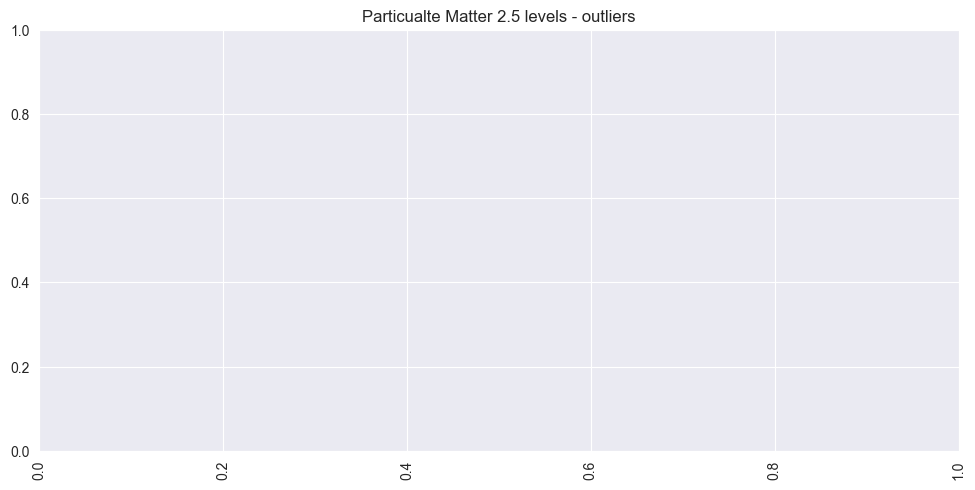

In [18]:
plt.figure(figsize=(20,20))
for number,col in enumerate(['month','day','hour']):
    plt.subplot(4,2,number*2+1)
    plt.title('Particualte Matter 2.5 levels - outliers')
    plt.xticks(rotation='vertical')
    plt.tight_layout(pad=3.0)
    sns.boxplot(df[col],df['PM2.5'])
    plt.subplot(4,2,number*2+2)
    plt.title('Particulate matter 2.5 levels - outliers with log')
    plt.xticks(rotation='vertical')
    plt.tight_layout(pad=3.0)
    sns.boxplot(df[col],np.log(df['PM2.5']))

In [ ]:
# günlük ve haftalık grafikler
df_daily = df.resample('D').mean()
df_weekly = df_daily.resample('W').mean()

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(y="PM2.5" ,x='Date',data=df_daily)

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(y="PM2.5" ,x='Date',data=df_weekly)

In [ ]:
def plot_data(col):
    plt.figure(figsize=(15,8))
    sns.lineplot(y=col ,x='Date',data=df_weekly)


for col in df_weekly.columns:
    plot_data(col)

In [ ]:
pollutant_corr = df_daily.corr()  # Pearson correlation
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(pollutant_corr, cmap=cmap, annot=True, vmax=1, center=0,
            square=True, linewidth=.5);

## Derin Öğrenme Aşaması

In [ ]:
# PARAMETERS
layer_size = 2
units =  30
SEED = 123
learning_rate = 0.01
layer = 'LSTM'
activation_function = 'relu'
dropout_rate = 0.1
epoch = 10
batch_size = 128
loss_function = 'mae'
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
return_sequence = True
target = 'PM2.5'
n_hours = 24
train_size = 0.8

# Aynı sonuçlar üretebilmek için
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
print("SEED Ayarlandı: ", SEED)


cols_to_analyze = [
    "PM2.5",
    "SO2",
    "NO2",
    "CO",
    "O3"
]

In [ ]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = pd.DataFrame(scaler.fit_transform(df[cols_to_analyze]),
                         index=df.index,
                         columns=cols_to_analyze)

In [ ]:
scaled_df.head(50)

In [ ]:
# reframe data
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
reframed_df = pd.DataFrame(
    series_to_supervised(scaled_df.to_numpy(), n_hours, len([target])))
# Düşürülecek sütunlar sondan özellik sayısından 1 eksik olana kadar gideceğiz.
reframed_df = reframed_df.iloc[:, :-(len(cols_to_analyze) - 1)]
reframed_df.index = df.index[n_hours:]

In [ ]:
reframed_df

In [ ]:
# split_data
X = reframed_df.iloc[:, :-1]
y = reframed_df.iloc[:, -1]
print(X.shape, "x", y.shape, "y")

In [ ]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X, y, train_size=train_size, shuffle=False)
X_train = X_train_df.to_numpy().reshape(
    (X_train_df.shape[0], n_hours, scaled_df.shape[1]))
X_test = X_test_df.to_numpy().reshape(
    (X_test_df.shape[0], n_hours, scaled_df.shape[1]))

In [ ]:
X_train.shape, y_train_df.shape, X_test.shape, y_test_df.shape

In [ ]:
print(X_train.shape, "X_train.shape")
print(X_test.shape, "X_test.shape")
print(y_train_df.shape, "y_train_df.shape")
print(y_test_df.shape, "y_test_df.shape")

In [ ]:
model = Sequential()
model.add(
    SimpleRNN(units,
              activation=activation_function,
              input_shape=(X_train.shape[1], X_train.shape[2]),
              return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(SimpleRNN(units, activation=activation_function))
model.add(Dropout(dropout_rate))
model.add(Dense(1))
model.compile(loss=loss_function, optimizer=optimizer)
history = model.fit(X_train,
                    y_train_df.to_numpy(),
                    epochs=epoch,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test_df.to_numpy()),
                    verbose=1,
                    shuffle=False)

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Train")
plt.plot(epochs, val_loss, "r", label="Test")
plt.title("history")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
scaler_pred = MinMaxScaler()
scaler_pred.fit(df[target].to_numpy().reshape(-1, 1))
y_pred_test = model.predict(
    X_test)  # yhat tahmin değerleri y_test ler ile kıyaslanacak.
# inverse scaling for forecast
inv_y_pred_test = scaler_pred.inverse_transform(y_pred_test)
y_true_test = scaler_pred.inverse_transform(y_test_df.to_numpy().reshape(
    -1, 1))
# make predictions (train)
y_pred_train = model.predict(
    X_train)  # yhat tahmin değerleri y_test ler ile kıyaslanacak.
# inverse scaling for forecast
inv_y_pred_train = scaler_pred.inverse_transform(y_pred_train)
y_true_train = scaler_pred.inverse_transform(y_train_df.to_numpy().reshape(
    -1, 1))

In [ ]:
# TEST
test_rmse = mean_squared_error(inv_y_pred_test, y_true_test, squared=False)
test_mae = mean_absolute_error(inv_y_pred_test, y_true_test)

In [ ]:
test_rmse

In [ ]:
test_mae

In [ ]:
plt.plot(y_true_test[:200], label="actual")
plt.plot(inv_y_pred_test[:200], label="prediction")
plt.legend()

In [ ]:
# train_test train için mi test için mi
plt.figure(figsize=(10, 10))
plt.scatter(y_true_test, inv_y_pred_test, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = max(max(inv_y_pred_test), max(y_true_test))
p2 = min(min(inv_y_pred_test), min(y_true_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
#plt.savefig("images/true_preds{}_{}.jpg".format(model_number, train_test))
plt.show()